In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
#import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
    species='human'
    SRP_name='aggregates'
    resolution='1kbp_raw'
    base_folder='/grid/gillis/data_norepl/lohia/'

In [91]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


#egad function

import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck


def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #print (nw_mask)
    nw = nw.loc[nw_mask, nw_mask].astype(float)
    #print (nw)
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)


def _runNV(go, nw, nFold=3, min_count=1, max_count=1000):

    #Make sure genes are same in go and nw
    genes_intersect = go.index.intersection(nw.index)

    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]

    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    
    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)


def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()
        
    CVgo = np.concatenate(list(cvgo.values()), axis=1)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)

    predicts = sumin / degree[:, None]

    np.place(predicts, CVgo > 0, np.nan)
    


    #Calculate ranks of positives
    #rank_abs = lambda x: stats.rankdata(np.abs(x))
    #predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    predicts2  = bottleneck.nanrankdata(abs(predicts), axis=0)


    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    


    filtering = np.tile(go, nFold)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)

    #Number of predictions
    #Number of 1's masked for each GO term for each CV
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn

    return roc, avg_degree, roc_null, P


tissue_dict = {'Chandelier': "brain",
 'Lamp5': "brain",
 'Lamp5_Lhx6': "brain",
 'Pax6': "brain",
 'Pvalb': "brain",
 'Sncg': "brain",
 'Sst': "brain",
 'Chandelier': "brain",
 'Sst Chodl': "brain",
 'Meis2': "brain",
 'Vip': "brain",
 'L2/3 IT': "brain",
 'L4 IT': "brain",
 'L5 ET': "brain",
 'L5 IT': "brain",
 'L5 PT': "brain",
 'L4/5 IT': "brain",
 'L5/6 NP': "brain",
 'L6 CT': "brain",
 'L6 IT': "brain",
 'L6 IT Car3': "brain",
 'L6b': "brain",
 'Astro': 'brain',
 'Endo': 'brain',
 'Micro-PVM': 'brain',
 'OPC': 'brain',
 'Oligo': "brain",
 'VLMC':'brain', 
 'Peri': 'brain',
 'SMC': 'brain',
 'T cell': 'heart',
 'basophil': 'heart',
 'erythroblast': 'heart',
 'granulocyte': 'heart',
 'hematopoietic precursor cell': 'heart',
 'immature B cell': 'heart',
 'immature natural killer cell': 'heart',
 'late pro-B cell': 'heart',
 'macrophage': 'heart',
 'monocyte': 'heart',
 'naive B cell': 'heart',
 'pro-B cell': 'heart',
 'proerythroblast' : 'heart',
 'Adipocytes' : 'heart',
 'Cardiomyocytes': 'heart',
 'Endocardial': 'heart',
 'Endothelial_Arterial': 'heart' ,
 'Endothelial_Capillaries': 'heart',
 'Endothelial_Other': 'heart',
 'Endothelial_Venous': 'heart',
 'Fibroblasts': 'heart',
 'Pericytes_Stromal': 'heart',
 'Smooth_Muscle_Cells': 'heart',
 'Pericytes': 'heart',
 'Epicardium_FB-like': 'heart',
 'Epicardium_Meso': 'heart',
 'Epicardium_Proliferating': 'heart',
 'Immature_Cardiomyocytes': 'heart',
 'Immature_other': 'heart',
 'Lymphoid_Immune_Cells': 'heart',
 'Myeloid_Immune_Cells': 'heart',
 'Neuronal_Cells': 'heart',}


NvsNN_dict = {'Chandelier': "N",
 'Lamp5': "N",
 'Lamp5_Lhx6': "N",
 'Pax6': "N",
 'Pvalb': "N",
 'Sncg': "N",
 'Sst': "N",
 'Chandelier': "N",
 'Sst Chodl': "N",
 'Meis2': "N",
 'Vip': "N",
 'L2/3 IT': "N",
 'L4 IT': "N",
 'L5 ET': "N",
 'L5 IT': "N",
 'L5 PT': "N",
 'L4/5 IT': "N",
 'L5/6 NP': "N",
 'L6 CT': "N",
 'L6 IT': "N",
 'L6 IT Car3': "N",
 'L6b': "N",
 'Astro': 'NN',
 'Endo': 'NN',
 'Micro-PVM': 'NN',
 'OPC': 'NN',
 'Oligo': "NN",
 'VLMC':'NN', 
 'Peri': 'NN',
 'SMC': 'NN',
}

GlutvsGaba_dict = {'Chandelier': "Gaba",
 'Lamp5': "Gaba",
 'Lamp5_Lhx6': "Gaba",
 'Pax6': "Gaba",
 'Pvalb': "Gaba",
 'Sncg': "Gaba",
 'Sst': "Gaba",
 'Chandelier': "Gaba",
 'Sst Chodl': "Gaba",
 'Meis2': "Gaba",
 'Vip': "Gaba",
 'L2/3 IT': "Glut",
 'L4 IT': "Glut",
 'L5 ET': "Glut",
 'L5 IT': "Glut",
 'L5 PT': "Glut",
 'L4/5 IT': "Glut",
 'L5/6 NP': "Glut",
 'L6 CT': "Glut",
 'L6 IT': "Glut",
 'L6 IT Car3': "Glut",
 'L6b': "Glut",
 }


def create_dict_from_columns(name_age_dict):
    # Create a dictionary from two columns of the DataFrame

    given_dict = name_age_dict.copy()
    
    n = len(given_dict.keys())
    tp_class = np.zeros((n, n))

    # Fill the diagonal elements with 1
    np.fill_diagonal(tp_class, 1)

    df_tp_class = pd.DataFrame(tp_class, index=given_dict.keys(), columns=given_dict.values())

    # Update the DataFrame based on the given_dict
    for key, value in given_dict.items():
        df_tp_class.loc[key, value] = 1

    # Remove duplicate columns
    df_tp_class = df_tp_class.loc[:, ~df_tp_class.columns.duplicated()]
    
    return df_tp_class

# Calculate the mean of genes for each category and observation, ignoring NaN values
def calculate_pearson_correlation(df_a, corr_method):
    # Calculate mean for each category (axis=0) and each observation (axis=1), ignoring NaN values


    df_corr = df_a.T.corr(min_periods=200, method=corr_method)
     
    return df_corr

# Call the function to calculate category means, ignoring NaN values



        

#for each marker-list and input file , I can make one output file

def calc_egad_vals(input_file_h5ad, outputfile_h5ad):

        

        adata = ad.read_h5ad(f'{input_file_h5ad}')
        
        np_of_col = len(adata.obs_names.tolist())
        np_of_rows = len(adata.obs_names.tolist())
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))
        
        layer_names = adata.layers.keys()    
        for corr_method in ['pearson']:
                        for given_layer in layer_names:



                                df_a = adata.to_df(layer=given_layer)

                                df_corr = calculate_pearson_correlation(df_a, corr_method)

                                l_n = f'{given_layer}_{corr_method}'

                                adata_l.layers[l_n] = df_corr

                                df_corr  = df_corr.fillna(0)
                                
                                df_corr += abs(df_corr.min().min())
                                
                                #print (df_corr)

                                #df_list  = []
                                
                                if marker_name == 'brain_class':
                                    name_age_dict =  NvsNN_dict.copy()
                                    class_name = ['NvsNN']
                                else:
                                    name_age_dict =  tissue_dict.copy()
                                    class_name = 'tissue'

                                #for name_age_dict, class_name in zip([tissue_dict , NvsNN_dict], ['tissue' , 'NvsNN']):

                                df_tp_class = create_dict_from_columns(name_age_dict)

                                df_exp = run_egad(df_tp_class, df_corr)

                                #    df_list.append(df_exp)
                                #df_exp = pd.concat(df_list)

                                adata_l.uns[l_n] = df_exp



        adata_l.obs_names = adata.obs_names.tolist()
        adata_l.var_names = adata.obs_names.tolist()

        adata_l.write(outputfile_h5ad, compression="gzip")



In [92]:


no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['mouse']:
        for process_type in ['intra', 'inter']:
            for resolution in [ '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [True, False]:
                        for marker_name in ['brain_class', 'brain_blood']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_egad.h5ad'
                            if os.path.isfile(outputfile_h5ad):
                                    pass
                            else:
                                    calc_egad_vals(input_file_h5ad, outputfile_h5ad)
                            

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:
    for species in ['human']:
        for process_type in ['intra', 'inter']:
            for resolution in [ '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [True, False]:
                        for marker_name in ['brain_class', 'brain_heart']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_egad.h5ad'
                            if os.path.isfile(outputfile_h5ad):
                                    pass
                            else:
                                    calc_egad_vals(input_file_h5ad, outputfile_h5ad)








In [ ]:





for species in ['mouse']:
    for process_type in ['intra']:
        for resolution in ['500kbp_raw', '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
            for shuf in [True, False]:
                for drop_duplicates in [False]:
                    for marker_name in ['brain_class']:
                        for dist in [0,1,10,100]:
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 


                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean_cross_species.h5ad'

                            if species == 'human':
                                species_b = 'mouse'
                            input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'

                            calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)





for species in ['mouse']:
    for process_type in ['inter']:
        for resolution in ['500kbp_raw', '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
            for shuf in [True, False]:
                for drop_duplicates in [False]:
                    for marker_name in ['brain_class']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean_cross_species.h5ad'

                            if species == 'human':
                                species_b = 'mouse'
                            input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'

                            calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)







for species in ['human']:
    for process_type in ['intra']:
        for resolution in ['500kbp_raw', '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
            for shuf in [True, False]:
                for drop_duplicates in [False]:
                    for marker_name in ['brain_class']:
                        for dist in [0,1,10,100]:
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean_cross_species.h5ad'

                            if species == 'human':
                                species_b = 'mouse'
                            input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'

                            calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)



for species in ['human']:
    for process_type in ['inter']:
        for resolution in ['500kbp_raw', '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
            for shuf in [True, False]:
                for drop_duplicates in [False]:
                    for marker_name in ['brain_class']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean_cross_species.h5ad'

                            if species == 'human':
                                species_b = 'mouse'
                            input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'

                            calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)


In [104]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


#egad function

import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
import os.path




def calculate_pearson_correlation(df, df_b, corr_method):
    # Perform bin intersection
    bins_intersect = set(df.columns.tolist()).intersection(set(df_b.columns.tolist()))
    df = df.loc[:, bins_intersect]
    #df = df.fillna(0)
    #df_b = df_b.fillna(0)
    df_b = df_b.loc[:, bins_intersect]


    # Z-score normalization
    df_b_z = stats.zscore(df_b, axis=0, nan_policy='omit')
    df_b_z = pd.DataFrame(df_b_z, index=df_b.index.tolist(), columns=df_b.columns)
    df_b_z['cell_type'] = df_b_z.index.tolist()
    df_b_z = df_b_z.set_index(['cell_type'])

    df_z = stats.zscore(df, axis=0, nan_policy='omit')
    df_z = pd.DataFrame(df_z, index=df.index.tolist(), columns=df.columns)
    df_z['cell_type'] = df_z.index.tolist()
    df_z['cell_type'] = [x + '_hic' for x in df_z['cell_type']]
    df_z = df_z.set_index(['cell_type'])
    

    # Concatenate dataframes
    #print (df_b_z)
    #print (df_z)
    print (df_b_z, df_z)
    df_corr = pd.concat([df_b_z, df_z], axis=0)

    
    
    #df_corr = df_corr.dropna(axis=1, how='all')
    #df_corr = df_corr.dropna(axis=1)
    
    #df_corr = df_corr.set_index(['cell_type'])

            
    #features_sc = stats.zscore(df_corr, axis=0, nan_policy='omit')
    
    #features_sc = features_sc.dropna(how='all', axis=1).fillna(0)
    
    #features_sc = features_sc.dropna(how='all', axis=1)
    
                
    df_dist_df = df_corr.T.corr(min_periods=10, method=corr_method)



    return df_dist_df


def calculate_auc_nan(df_dist_df, tp):
    df_jac_subset = df_dist_df.values
    df_exp_subset = tp.values

    coodinates_1 = np.where(np.isnan(df_jac_subset))
    coodinates_2 = np.where(np.isnan(df_exp_subset))

    x_coo = coodinates_1[0].tolist() + coodinates_2[0].tolist()
    y_coo = coodinates_1[1].tolist() + coodinates_2[1].tolist()

    df_jac_subset[x_coo, y_coo] = np.nan
    df_exp_subset[x_coo, y_coo] = np.nan

    predicts2 = bottleneck.nanrankdata(df_jac_subset, axis=1)

    tp = df_exp_subset.copy()
    tn = 1 - tp

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)

    df_auc = pd.DataFrame({'cell_type': df_dist_df.index.tolist(), 'AUC': auc_array})

    return df_auc

cell_type_map = {
 'Adipocyte' : 'Adipocytes',
 'Atrial Cardiomyocyte': 'Cardiomyocytes',
 'Ventricular Cardiomyocyte':'Immature_Cardiomyocytes',
 'Endothelial_Arterial': 'Endothelial' ,
 'Fibroblast': 'Fibroblasts',
 'Smooth Muscle': 'Smooth_Muscle_Cells',
 'Lymphocyte': 'Lymphoid_Immune_Cells',
 'Macrophage': 'Myeloid_Immune_Cells',
 'Nervous': 'Neuronal_Cells',}
        

#for each marker-list and input file , I can make one output file

def calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name):
    

        adata = ad.read_h5ad(f'{input_file_h5ad}', backed='r')
        adata_b = ad.read_h5ad(f'{input_file_another_exp_h5ad}', backed='r')
        df_b = adata_b.to_df()
        
        if marker_name == 'heart':
            df_b.index = [cell_type_map[x] for x in cell_type_map]

        df = adata.to_df()

        cell_type_intersect = df.index.intersection(df_b.index)


        df_b = df_b.loc[cell_type_intersect,:]
        

        np_of_col = len(cell_type_intersect)*2
        np_of_rows = len(cell_type_intersect)*2
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))

        
        layer_names = adata.layers.keys()    
        for corr_method in ['pearson']:
                        for given_layer in layer_names:
                        #for given_layer in accepted_layer_list:
                        
                        


                                df = adata.to_df(layer=given_layer)

                                df = df.loc[cell_type_intersect,:]

                                df_corr_real_names = calculate_pearson_correlation(df, df_b, corr_method)

                                l_n = f'{given_layer}_{corr_method}'

                                adata_l.layers[l_n] = df_corr_real_names

                                # Perform cell type intersection
                                #cell_type_intersect = df.index.intersection(df_b.index)

                                hic_cell_type = [x + '_hic' for x in cell_type_intersect]

                                df_corr = df_corr_real_names.loc[cell_type_intersect,:]
                            
                                df_corr = df_corr[hic_cell_type]

                                #df_corr  = df_corr.fillna(0)

                                #df_corr += abs(df_corr.min().min())

                                given_dict = dict(zip(df_corr.index.tolist(), df_corr.index.tolist()))

                                n = len(given_dict.keys())

                                tp_class = np.zeros((n, n))

                                # Fill the diagonal elements with 1
                                np.fill_diagonal(tp_class, 1)

                                df_tp_class = pd.DataFrame(tp_class, index=given_dict.keys(), columns=given_dict.values())

                                for key, value in given_dict.items():
                                    df_tp_class.loc[key, value] = 1
                            
                                df_tp_class = df_tp_class.loc[df_corr.index.tolist(), :]
                                    
                                    
                                df_exp = calculate_auc_nan(df_corr, df_tp_class)

                                adata_l.uns[l_n] = df_exp



        adata_l.obs_names = df_corr_real_names.index.tolist()
        adata_l.var_names = df_corr_real_names.columns.tolist()

        adata_l.write(outputfile_h5ad, compression="gzip")


In [ ]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['mouse']:
        for process_type in ['intra']:
            for resolution in ['1kbp_raw']:
                for shuf in [False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                            for dist in [0]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'
                                
                                if os.path.isfile(outputfile_h5ad):
                                    pass
                                else:
                                    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                if os.path.isfile(outputfile_h5ad):
                                    pass
                                else:
                                    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)





/home/lohia/miniconda3/envs/hicexplorer/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [97]:
input_file_h5ad

'/grid/gillis/data_norepl/lohia//hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/hic_gene_intra_KR_0_z_scores_False_False_brain_class_1_by_allbins_max_mean.h5ad'

In [98]:
adata = ad.read_h5ad(f'{input_file_h5ad}', backed='r')

In [102]:
adata.layers

Layers with keys: counts, mean

In [103]:

adata.to_df(layer='counts')

bin_0  bin_1  bin_2  bin_3  bin_4  bin_5  bin_6  bin_7  bin_8  \
Lamp5         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Pvalb         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Sncg          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Sst           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Sst Chodl     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Vip           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
L2/3 IT       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
L4/5 IT       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
L5 IT         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
L5 PT         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
L5/6 NP       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
L6 CT         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
L6 IT         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
L6 IT Car3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
L6b           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Astro         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Endo          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Meis2         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Micro-PVM     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Oligo         1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Peri          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
SMC           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
VLMC          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

            bin_9  ...  bin_2462745  bin_2462746  bin_2462747  bin_2462748  \
Lamp5         0.0  ...          0.0          0.0          0.0          0.0   
Pvalb         0.0  ...          0.0          0.0          0.0          0.0   
Sncg          0.0  ...          0.0          0.0          0.0          0.0   
Sst           0.0  ...          0.0          0.0          0.0          0.0   
Sst Chodl     0.0  ...          0.0          0.0          0.0          0.0   
Vip           0.0  ...          0.0          0.0          0.0          0.0   
L2/3 IT       0.0  ...          0.0          0.0          0.0          0.0   
L4/5 IT       0.0  ...          0.0          0.0          0.0          0.0   
L5 IT         0.0  ...          0.0          0.0          0.0          0.0   
L5 PT         0.0  ...          0.0          0.0          0.0          0.0   
L5/6 NP       0.0  ...          0.0          0.0          0.0          0.0   
L6 CT         0.0  ...          0.0          0.0          0.0          0.0   
L6 IT         0.0  ...          0.0          0.0          0.0          0.0   
L6 IT Car3    0.0  ...          0.0          0.0          0.0          0.0   
L6b           0.0  ...          0.0          0.0          0.0          0.0   
Astro         0.0  ...          0.0          0.0          0.0          0.0   
Endo          0.0  ...          0.0          0.0          0.0          0.0   
Meis2         0.0  ...          0.0          0.0          0.0          0.0   
Micro-PVM     0.0  ...          0.0          0.0          0.0          0.0   
Oligo         1.0  ...          0.0          0.0          0.0          0.0   
Peri          0.0  ...          0.0          0.0          0.0          0.0   
SMC           0.0  ...          0.0          0.0          0.0          0.0   
VLMC          0.0  ...          0.0          0.0          0.0          0.0   

            bin_2462749  bin_2462750  bin_2462751  bin_2462752  bin_2462753  \
Lamp5               0.0          0.0          0.0          0.0          0.0   
Pvalb               0.0          0.0          0.0          0.0          0.0   
Sncg                0.0          0.0          0.0    

In [ ]:
no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['mouse']:
        for process_type in ['inter']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                                dist = 0
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'
                                if os.path.isfile(outputfile_h5ad):
                                    pass
                                else:
                                    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)



                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                if os.path.isfile(outputfile_h5ad):
                                    pass
                                else:
                                    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)









In [ ]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:
    for species in ['human']:
        for process_type in ['intra']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw', '1kbp_raw']:
                for shuf in [False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                            for dist in [0]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                #marker_name = 'heart'

                                #input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                #input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_heart.h5ad'
                                #outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                #calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)




    for species in ['human']:
        for process_type in ['inter']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw', '1kbp_raw']:
                for shuf in [False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                                dist = 0
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                #marker_name = 'heart'

                                #input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                #input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_heart.h5ad'
                                #outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                #calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)



In [80]:
df_list = []
no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:
    for species in ['mouse']:
        for process_type in ['intra']:
            for resolution in ['10kbp_raw']:
                for shuf in [False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                            for dist in [0,1,10,100]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                #calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)
                                
                                adata = ad.read_h5ad(f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad', backed='r')
                                df = adata.uns['mean_pearson']
                                df['resolution'] = resolution
                                df['no_of_markers'] = no_of_markers
                                df['dist'] = dist
                                df_list.append(df)


                                #marker_name = 'heart'

                                #input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                #input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_heart.h5ad'
                                #outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                #calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)




In [81]:
df = pd.concat(df_list)

In [82]:
df.dropna()

cell_type       AUC resolution  no_of_markers  dist
0       Lamp5  0.000000  10kbp_raw              1     0
4   Sst Chodl  0.444444  10kbp_raw              1     0
5         Vip  0.555556  10kbp_raw              1     0
7       L5 IT  0.888889  10kbp_raw              1     0
8     L5/6 NP  0.777778  10kbp_raw              1     0
..        ...       ...        ...            ...   ...
12      Astro  0.812500  10kbp_raw            500   100
13       Endo  0.062500  10kbp_raw            500   100
14  Micro-PVM  1.000000  10kbp_raw            500   100
15      Oligo  0.625000  10kbp_raw            500   100
16       VLMC  0.812500  10kbp_raw            500   100

[3096 rows x 5 columns]

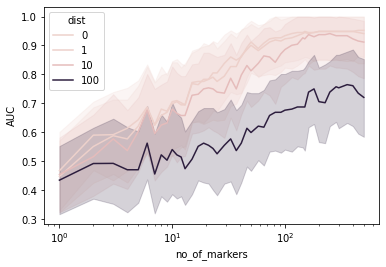

In [83]:
        sns.lineplot(data=df.fillna(0.5), x='no_of_markers', y='AUC', hue='dist')
        plt.xscale('log')
        plt.show()

In [16]:
dist=0
adata = ad.read_h5ad(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad', backed='r')



In [17]:
adata.layers

Layers with keys: counts_pearson, mean_pearson

In [ ]:
adata.uns['counts_pearson']['AUC'].mean()

In [44]:
adata.to_df(layer='counts_pearson')

Lamp5      Sncg     L5 IT     Pvalb   L2/3 IT     L6 IT  \
Lamp5          1.000000  0.153253 -0.128119  0.047243 -0.109724 -0.155304   
Sncg           0.153253  1.000000 -0.171469  0.050555 -0.145082 -0.215889   
L5 IT         -0.128119 -0.171469  1.000000 -0.136182  0.272472  0.275258   
Pvalb          0.047243  0.050555 -0.136182  1.000000 -0.124910 -0.156400   
L2/3 IT       -0.109724 -0.145082  0.272472 -0.124910  1.000000  0.306081   
L6 IT         -0.155304 -0.215889  0.275258 -0.156400  0.306081  1.000000   
L6b           -0.053881 -0.107992  0.131074 -0.077712  0.075349  0.094960   
Astro         -0.004865 -0.002659 -0.168015 -0.050597 -0.148417 -0.150118   
Micro-PVM     -0.089314 -0.139284 -0.021976 -0.123807 -0.035077  0.027496   
Oligo         -0.071461 -0.064424 -0.152742 -0.056300 -0.137705 -0.118822   
VLMC          -0.123902 -0.125312 -0.078160 -0.139195 -0.087884 -0.044522   
Sst Chodl     -0.016151  0.027803 -0.186049  0.167045 -0.179183 -0.219861   
Vip            0.042517  0.232141 -0.127896  0.009376 -0.116591 -0.147185   
L6 CT         -0.088517 -0.136383  0.242172 -0.119280  0.190395  0.165307   
L5 ET         -0.046307 -0.037532  0.004529 -0.006518  0.011952 -0.048864   
Sst           -0.016151  0.027803 -0.186049  0.167045 -0.179183 -0.219861   
L5/6 NP       -0.044044 -0.019331 -0.020124 -0.030468 -0.047427 -0.051439   
Endo          -0.097142 -0.192539  0.100209 -0.164667  0.090846  0.165905   
Lamp5_hic      0.001076  0.029675 -0.011039 -0.019343  0.000476 -0.015405   
Sncg_hic      -0.021771  0.003565  0.031537 -0.014617 -0.001647  0.017207   
L5 IT_hic     -0.023615 -0.036452  0.052101  0.007030  0.052619  0.055808   
Pvalb_hic     -0.003884 -0.028428  0.011343  0.005292  0.013520  0.014291   
L2/3 IT_hic   -0.012107  0.006332 -0.012592 -0.025296  0.002504 -0.018518   
L6 IT_hic      0.005276 -0.007512 -0.002053 -0.001427  0.021997  0.024774   
L6b_hic       -0.039177 -0.053531  0.028736 -0.005450  0.034685  0.029228   
Astro_hic      0.000252 -0.016373 -0.035499  0.002369 -0.013998 -0.023708   
Micro-PVM_hic  0.030259  0.018531  0.003468  0.009188 -0.030000 -0.009921   
Oligo_hic      0.024826  0.007539 -0.032551  0.021657  0.001958 -0.009617   
VLMC_hic      -0.007922  0.012545 -0.003254  0.004041 -0.023651  0.005560   
Sst Chodl_hic  0.002903 -0.005061 -0.017668  0.004583 -0.019324 -0.029562   
Vip_hic        0.019830  0.049719 -0.014840 -0.007015 -0.021328 -0.032797   
L6 CT_hic      0.022962 -0.000749  0.009847  0.019535  0.035776  0.021370   
L5 ET_hic      0.011155  0.045511 -0.008376  0.009106 -0.010100 -0.004861   
Sst_hic       -0.028578 -0.018485  0.021909 -0.021372  0.012656  0.018787   
L5/6 NP_hic   -0.006145 -0.041867  0.010737  0.002087 -0.007519 -0.014828   
Endo_hic       0.000681  0.027765 -0.010198 -0.000721 -0.024530 -0.010568   

                    L6b     Astro  Micro-PVM     Oligo  ...  Micro-PVM_hic  \
Lamp5         -0.053881 -0.004865  -0.089314 -0.071461  ...       0.030259   
Sncg          -0.107992 -0.002659  -0.139284 -0.064424  ...       0.018531   
L5 IT          0.131074 -0.168015  -0.021976 -0.152742  ...       0.003468   
Pvalb         -0.077712 -0.050597  -0.123807 -0.056300  ...       0.009188   
L2/3 IT        0.075349 -0.148417  -0.035077 -0.137705  ...      -0.030000   
L6 IT          0.094960 -0.150118   0.027496 -0.118822  ...      -0.009921   
L6b            1.000000 -0.125718  -0.072689 -0.133802  ...      -0.000716   
Astro         -0.125718  1.000000  -0.053845  0.069421  ...       0.006097   
Micro-PVM     -0.072689 -0.053845   1.000000 -0.059693  ...      -0.001847   
Oligo         -0.133802  0.069421  -0.059693  1.000000  ...      -0.001230   
VLMC          -0.085298 -0.020988  -0.029966 -0.048087  ...      -0.009555   
Sst Chodl     -0.126371 -0.124787  -0.147762 -0.086889  ...       0.005419   
Vip           -0.126481 -0.004199  -0.087509 -0.028200  ...       0.006087   
L6 CT          0.222889 -0.137134  -0.055329 -0.113692  ...      -0.008711  

<AxesSubplot:>

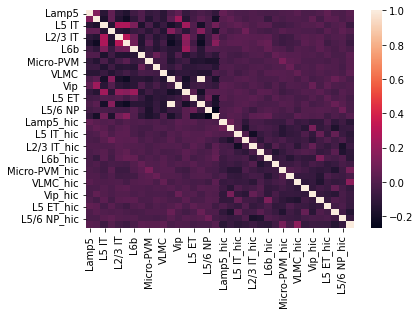

In [45]:
sns.heatmap(adata.to_df(layer='mean_pearson').copy())

In [84]:
for resolution in ['10kbp_raw', '1kbp_raw']:
        file_b_species = 'mouse'
        if file_b_species == 'mouse':
            species_input='mouse'
            species_output='human'
        else:
            species_input='human'
            species_output='mouse'
        
        full_input_path = f'{base_folder}/hi_c_data_processing/data_{species_input}/{SRP_name}/{resolution}/max/'
        
        full_target_path = f'{base_folder}/hi_c_data_processing/data_{species_output}/{SRP_name}/{resolution}/max/'
        if species_input=='mouse':
            chain_file = 'mm10ToHg38.over.chain.gz'
        else:
            chain_file = 'hg38ToMm10.over.chain.gz'
        for minmatch in [0.5]:

            os.system(f"{base_folder}/hi_c_data_processing/software/liftOver -minMatch={minmatch} {full_input_path}/regions_bed_file.tsv {base_folder}/hi_c_data_processing/software/{chain_file} {full_input_path}/minmatch{minmatch}_{species_input}_to_{species_output}.bed u")


In [85]:
for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw']:
        file_b_species = 'mouse'
        if file_b_species == 'mouse':
            species_input='mouse'
            species_output='human'
        else:
            species_input='human'
            species_output='mouse'
        
        full_input_path = f'{base_folder}/hi_c_data_processing/data_{species_input}/{SRP_name}/{resolution}/max/'
        
        full_target_path = f'{base_folder}/hi_c_data_processing/data_{species_output}/{SRP_name}/{resolution}/max/'
        if species_input=='mouse':
            chain_file = 'mm10ToHg38.over.chain.gz'
        else:
            chain_file = 'hg38ToMm10.over.chain.gz'
        for minmatch in [0.5]:

            os.system(f"{base_folder}/hi_c_data_processing/software/liftOver -minMatch={minmatch} {full_input_path}/regions_bed_file.tsv {base_folder}/hi_c_data_processing/software/{chain_file} {full_input_path}/minmatch{minmatch}_{species_input}_to_{species_output}.bed u")


In [86]:
for resolution in ['10kbp_raw', '1kbp_raw','250kbp_raw', '100kbp_raw', '40kbp_raw']:
        file_b_species = 'human'
        if file_b_species == 'mouse':
            species_input='mouse'
            species_output='human'
        else:
            species_input='human'
            species_output='mouse'
        
        full_input_path = f'{base_folder}/hi_c_data_processing/data_{species_input}/{SRP_name}/{resolution}/max/'
        
        full_target_path = f'{base_folder}/hi_c_data_processing/data_{species_output}/{SRP_name}/{resolution}/max/'
        if species_input=='mouse':
            chain_file = 'mm10ToHg38.over.chain.gz'
        else:
            chain_file = 'hg38ToMm10.over.chain.gz'
        for minmatch in [0.5]:

            os.system(f"{base_folder}/hi_c_data_processing/software/liftOver -minMatch={minmatch} {full_input_path}/regions_bed_file.tsv {base_folder}/hi_c_data_processing/software/{chain_file} {full_input_path}/minmatch{minmatch}_{species_input}_to_{species_output}.bed u")


In [ ]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


#egad function

import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck




def calculate_pearson_correlation(df, df_b, corr_method):
    # Perform bin intersection
    bins_intersect = set(df.columns.tolist()).intersection(set(df_b.columns.tolist()))
    df = df.loc[:, bins_intersect]
    #df = df.fillna(0)
    #df_b = df_b.fillna(0)
    df_b = df_b.loc[:, bins_intersect]


    # Z-score normalization
    df_b_z = stats.zscore(df_b, axis=0, nan_policy='omit')
    df_b_z = pd.DataFrame(df_b_z, index=df_b.index.tolist(), columns=df_b.columns)
    df_b_z['cell_type'] = df_b_z.index.tolist()
    df_b_z = df_b_z.set_index(['cell_type'])

    df_z = stats.zscore(df, axis=0, nan_policy='omit')
    df_z = pd.DataFrame(df_z, index=df.index.tolist(), columns=df.columns)
    df_z['cell_type'] = df_z.index.tolist()
    df_z['cell_type'] = [x + '_hic' for x in df_z['cell_type']]
    df_z = df_z.set_index(['cell_type'])
    

    # Concatenate dataframes
    df_corr = pd.concat([df_b_z, df_z])

    
    
    #df_corr = df_corr.dropna(axis=1, how='all')
    #df_corr = df_corr.dropna(axis=1)
    
    #df_corr = df_corr.set_index(['cell_type'])

            
    features_sc = stats.zscore(df_corr, axis=0, nan_policy='omit')
    
    #features_sc = features_sc.dropna(how='all', axis=1).fillna(0)
    
    #features_sc = features_sc.dropna(how='all', axis=1)
    
                
    df_dist_df = features_sc.T.corr(min_periods=200, method=corr_method)



    return df_dist_df


def calculate_auc_nan(df_dist_df, tp):
    df_jac_subset = df_dist_df.values
    df_exp_subset = tp.values

    coodinates_1 = np.where(np.isnan(df_jac_subset))
    coodinates_2 = np.where(np.isnan(df_exp_subset))

    x_coo = coodinates_1[0].tolist() + coodinates_2[0].tolist()
    y_coo = coodinates_1[1].tolist() + coodinates_2[1].tolist()

    df_jac_subset[x_coo, y_coo] = np.nan
    df_exp_subset[x_coo, y_coo] = np.nan

    predicts2 = bottleneck.nanrankdata(df_jac_subset, axis=1)

    tp = df_exp_subset.copy()
    tn = 1 - tp

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)

    df_auc = pd.DataFrame({'cell_type': df_dist_df.index.tolist(), 'AUC': auc_array})

    return df_auc


        

#for each marker-list and input file , I can make one output file

def calc_pair_corr(input_file_h5ad_a, input_file_h5ad_b, file_b_species, outputfile_h5ad, resolution, base_folder, SRP_name):

        adata = ad.read_h5ad(f'{input_file_h5ad_a}', backed='r')
        adata_b = ad.read_h5ad(f'{input_file_h5ad_b}', backed='r')
        df_b = adata_b.to_df()

        df = adata.to_df()

        cell_type_intersect = df.index.intersection(df_b.index)




        species_input='mouse'
        species_output='human'
        
        if file_b_species == 'mouse':
            species_input='mouse'
            species_output='human'
        else:
            species_input='human'
            species_output='mouse'
        
        full_input_path = f'{base_folder}/hi_c_data_processing/data_{species_input}/{SRP_name}/{resolution}/max/'
        
        full_target_path = f'{base_folder}/hi_c_data_processing/data_{species_output}/{SRP_name}/{resolution}/max/'
        if species_input=='mouse':
            chain_file = 'mm10ToHg38.over.chain.gz'
        else:
            chain_file = 'hg38ToMm10.over.chain.gz'
        for minmatch in [0.5]:

            os.system(f"{base_folder}/hi_c_data_processing/software/liftOver -minMatch={minmatch} {full_input_path}/regions_bed_file.tsv {base_folder}/hi_c_data_processing/software/{chain_file} {full_input_path}/minmatch{minmatch}_{species_input}_to_{species_output}.bed u")

            os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {full_input_path}/minmatch{minmatch}_{species_input}_to_{species_output}.bed -a {full_target_path}/regions_bed_file.tsv > {full_target_path}/minmatch{minmatch}_{species_input}_to_{species_output}_matched.bed")

            if species_output=='human':

                df_human_mouse_bins = pd.read_csv(f'{full_target_path}/minmatch{minmatch}_{species_input}_to_{species_output}_matched.bed', sep='\t', names=['a', 'b', 'c', 'human_bin', 'a1', 'b1', 'c1', 'mouse_bin', 'overlap'])
            else:
                df_human_mouse_bins = pd.read_csv(f'{full_target_path}/minmatch{minmatch}_{species_input}_to_{species_output}_matched.bed', sep='\t', names=['a', 'b', 'c', 'mouse_bin', 'a1', 'b1', 'c1', 'human_bin', 'overlap'])

        #correct bin_id to correct bin_id

        df_human_mouse_bins['mouse_bin'] = [f"bin_{i}" for i in df_human_mouse_bins['mouse_bin'].tolist()]
        df_human_mouse_bins['human_bin'] = [f"bin_{i}" for i in df_human_mouse_bins['human_bin'].tolist()]


        dk_human = df.copy()
        dk_mouse = df_b.copy()

        df_human_mouse_bins  = df_human_mouse_bins[df_human_mouse_bins['mouse_bin'].isin(dk_mouse.T.index.tolist())]
        df_human_mouse_bins  = df_human_mouse_bins[df_human_mouse_bins['human_bin'].isin(dk_human.T.index.tolist())]
                

        np_of_col = len(cell_type_intersect)*2
        np_of_rows = len(cell_type_intersect)*2
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))

        
        layer_names = adata.layers.keys()    
        for corr_method in ['pearson']:
                        for given_layer in layer_names:


                                df = adata.to_df(layer=given_layer)

                                df = df.loc[cell_type_intersect,:]

                                df_b = adata_b.to_df(layer=given_layer)

                                df_b = df_b.loc[cell_type_intersect,:]


                                df = df.loc[:,df_human_mouse_bins['human_bin'].tolist()]

                                df = df.T
                                df.index = df_human_mouse_bins['mouse_bin'].tolist()
                                df = df.T
                                df_b = df_b.loc[:,df_human_mouse_bins['mouse_bin'].tolist()]




                                df_corr_real_names = calculate_pearson_correlation(df, df_b, corr_method)

                                l_n = f'{given_layer}_{corr_method}'

                                adata_l.layers[l_n] = df_corr_real_names

                                # Perform cell type intersection
                                #cell_type_intersect = df.index.intersection(df_b.index)

                                hic_cell_type = [x + '_hic' for x in cell_type_intersect]

                                df_corr = df_corr_real_names.loc[cell_type_intersect,:]
                            
                                df_corr = df_corr[hic_cell_type]

                                #df_corr  = df_corr.fillna(0)

                                #df_corr += abs(df_corr.min().min())

                                given_dict = dict(zip(df_corr.index.tolist(), df_corr.index.tolist()))

                                n = len(given_dict.keys())

                                tp_class = np.zeros((n, n))

                                # Fill the diagonal elements with 1
                                np.fill_diagonal(tp_class, 1)

                                df_tp_class = pd.DataFrame(tp_class, index=given_dict.keys(), columns=given_dict.values())

                                for key, value in given_dict.items():
                                    df_tp_class.loc[key, value] = 1
                            
                                df_tp_class = df_tp_class.loc[df_corr.index.tolist(), :]
                                    
                                    
                                df_exp = calculate_auc_nan(df_corr, df_tp_class)

                                adata_l.uns[l_n] = df_exp



        adata_l.obs_names = df_corr_real_names.index.tolist()
        adata_l.var_names = df_corr_real_names.columns.tolist()

        adata_l.write(outputfile_h5ad, compression="gzip")


base_folder = '/grid/gillis/data_norepl/lohia/'
species='human'
resolution='500kbp_raw'
SRP_name='aggregates'
process_type='intra'
ice_type='KR'
input_file_h5ad=f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_by_allbins_max.h5ad'
if species=='mouse':
    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
else:
    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
    
    


dist=0
layer_name = 'z_scores'
input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'


marker_name = 'brain_class'
drop_duplicates = True
shuf = False



In [ ]:





for species in ['mouse']:
    for process_type in ['intra']:
        for resolution in ['500kbp_raw', '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
            for shuf in [True, False]:
                for drop_duplicates in [False]:
                    for marker_name in ['brain_class']:
                        for dist in [0,1,10,100]:
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 


                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean_cross_species.h5ad'

                            if species == 'human':
                                species_b = 'mouse'
                            input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'

                            calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)





for species in ['mouse']:
    for process_type in ['inter']:
        for resolution in ['500kbp_raw', '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
            for shuf in [True, False]:
                for drop_duplicates in [False]:
                    for marker_name in ['brain_class']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean_cross_species.h5ad'

                            if species == 'human':
                                species_b = 'mouse'
                            input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'

                            calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)







for species in ['human']:
    for process_type in ['intra']:
        for resolution in ['500kbp_raw', '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
            for shuf in [True, False]:
                for drop_duplicates in [False]:
                    for marker_name in ['brain_class']:
                        for dist in [0,1,10,100]:
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean_cross_species.h5ad'

                            if species == 'human':
                                species_b = 'mouse'
                            input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'

                            calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)



for species in ['human']:
    for process_type in ['inter']:
        for resolution in ['500kbp_raw', '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
            for shuf in [True, False]:
                for drop_duplicates in [False]:
                    for marker_name in ['brain_class']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean_cross_species.h5ad'

                            if species == 'human':
                                species_b = 'mouse'
                            input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'

                            calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)


In [ ]:
        for process_type in ['gw']:
            for layer_type, dist in zip(['inter'], [0]) :
                    #no_of_markers_list = []
                    #no_of_markers_list = [58,102,202]:
                    no_of_markers_list = [500]
                    for no_of_markers in no_of_markers_list:
                        for drop_duplicates in [True]:
                            for shuf in [False]:
                                for given_layer in ['z_scores']:
                                    for inp_norm in ['mean']:
                                    #for inp_norm in ['mean', 'counts', 'mean_scaled']:
                                        for corr_method in ['pearson']:
                                            if given_layer == 'none':
                                                l_n = f'{process_type}_{layer_type}_{dist}_{no_of_markers}_{drop_duplicates}_{shuf}_{inp_norm}'
                                            else:
                                                l_n = f'{process_type}_{layer_type}_{dist}_{given_layer}_{no_of_markers}_{drop_duplicates}_{shuf}_{inp_norm}'
                                            key = f'{species}_brain_class_{resolution}'
                                            df_layer = adata_list[key].to_df(layer=l_n).copy()
                                            df_layer_list.append(df_layer)
                                            

                                            # Access the existing DataFrame from adata.uns[l_n]
        

In [ ]:
# if species == 'human':
                    max_bins = 38

                    module_path = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/human/li2023/tables10_cis_modules.bed'

                    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -a {module_path} -b {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv > {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/cre_modules.bed")
                    df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id', 'overlap'])
                else:
                    max_bins = 151
                    module_path = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Zu_nature2023/'


                    df = pd.read_csv(f'{module_path}/s10_cre_modules.txt', sep='\t')

                    import re
                    df['chrom'] = [re.split(":|-", x)[0] for x in df['cCRE']]
                    df['st'] = [re.split(":|-", x)[1] for x in df['cCRE']]
                    df['end'] = [re.split(":|-", x)[2] for x in df['cCRE']]

                    df[['chrom', 'st', 'end', 'module']].to_csv(f'{module_path}/s10_cre_modules.bed',index=False, header=False, sep='\t')
                    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -a {module_path}/s10_cre_modules.bed -b {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv > {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/cre_modules.bed")
                    df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/cre_modules.bed', sep='\t', names=['d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id', 'overlap'])


In [1]:
kl

NameError: name 'kl' is not defined

In [ ]:
df_hba_modules['bin_id'] = ['bin_'+str(x) for x in df_hba_modules['bin_id'].tolist()]

df_hba_modules['rank'] = 1

marker_table = pd.pivot_table(df_hba_modules, columns='ccre', index='bin_id', values='rank', aggfunc='sum')
marker_table.fillna(0, inplace=True)

marker_table[marker_table != 0] = 1

df_input = df_layer.T

category_means, category_counts =  calculate_category_means_ignore_nan(df_input, marker_table)

df = pd.DataFrame(data=category_means,    # values
...              index=marker_table.columns.tolist(),    # 1st column as index
...              columns=df_input.columns.tolist()) 

df = df.T

unique_classes = list(set(class2_dict.values()))
palette = sns.color_palette('Set1', len(unique_classes))
class_color_map = dict(zip(unique_classes, palette))

# Map the class_dict to colors

row_colors = df.index.map(class2_dict).map(class_color_map)

sns.clustermap(df,col_cluster=True,row_cluster=True, z_score=1, row_colors=row_colors,yticklabels=True, figsize=(22,10))



In [ ]:


    plt.figure(figsize=(10, 6))
    pca = PCA(n_components=2, random_state=1)
    proj_2d = pca.fit_transform(df_layer)
    #proj_2d = pca.fit_transform(R1)
    #umap_2d = UMAP(n_components=2, init='random', random_state=10)
    #proj_2d = umap_2d.fit_transform(features_sc)

    df_proj_2d = pd.DataFrame(proj_2d, columns=['PC1', 'PC2'])

    # Access explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    
    df_proj_2d['subclass'] = [class2_dict[x] for x in df_layer.index.tolist()]
    df_proj_2d['cell_type'] = df_layer.index.tolist()
    #df_proj_2d = df_proj_2d.sort_values(by=['subclass'])



    ax = sns.scatterplot(
        x=df_proj_2d['PC1'],
        y=df_proj_2d['PC2'],
        hue=df_proj_2d['subclass'],
        s=300,
        linewidth=0, 
        palette=class_color_map,
        legend=False , alpha=0.5# Remove legend box
    )
    # Initialize list to store labeled point positions
    labeled_points = []

    # Add text labels with adjusted positions to reduce overlap
    for i, row in df_proj_2d.iterrows():
        # Define offset values based on the scale of the plot and density of points
        x_offset = 10
        y_offset = 0
        # Check if label overlaps with any existing label
        while any(abs(row[0] - x) < x_offset and abs(row[1] - y) < y_offset for x, y, _ in labeled_points):
            x_offset += 1
            y_offset += 1
        # Add label to the plot with adjusted positions
        #plt.text(row[0] + x_offset, row[1] + y_offset, str(row['cell_type']), fontsize=8, ha='center', va='center')
        # Record labeled point to avoid overlapping
        #labeled_points.append((row[0] + x_offset, row[1] + y_offset, row['cell_type']))
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    
    ax.set_xlabel(f'PC1 ({explained_variance_ratio[0]*100:.2f}% of variation)',fontsize=20)
    ax.set_ylabel(f'PC2 ({explained_variance_ratio[1]*100:.2f}% of variation)',fontsize=20)


    # Show the plot
    #plt.show()
    plt.show()
    #plt.plot()